In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import math
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential 
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
import os
from sklearn.metrics import mean_squared_error , mean_absolute_error , mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import LSTM , Dense , Dropout , GRU , Concatenate , Input , Conv1D , InputLayer
from tensorflow.keras import models
from tensorflow.keras.callbacks import EarlyStopping

<Strong> Grabbing the data from stored files (originally pulled from Binance) </Strong>

In [3]:
df_eth = pd.read_csv("ETH_1h_data.csv")

In [4]:
df_eth

,date,open,high,low,close,volume
0,2017-08-17 04:00:00.000,301.13,302.57,298.00,301.61,125.66877
1,2017-08-17 05:00:00.000,301.61,303.28,300.00,303.10,377.67246
2,2017-08-17 06:00:00.000,302.40,304.44,301.90,302.68,303.86672
3,2017-08-17 07:00:00.000,302.68,307.96,302.60,307.96,754.74510
4,2017-08-17 08:00:00.000,307.95,309.97,307.00,308.62,150.75029
...,...,...,...,...,...,...
39216,2022-02-11 10:00:00,3102.22,3115.98,3075.24,3106.33,12865.43100
39217,2022-02-11 11:00:00,3106.34,3109.86,3083.93,3088.30,7796.24450
39218,2022-02-11 12:00:00,3088.30,3122.00,3079.16,3102.23,13475.38960
39219,2022-02-11 13:00:00,3102.22,3127.00,3095.00,3121.64,13585.96880


In [5]:
df_headers = df_eth.columns

<Strong> Grabbing the closing price (univariate) </Strong>

In [6]:
# Removing everything but the closing price
eth_data = df_eth.values[:, 4 ,].astype(float)

len(eth_data)

39221

<Strong> Scaling the data  </Strong>

In [7]:
percTrain = 70
percVal = 20

onePercent = len(eth_data) // 100
numberTraining = onePercent * percTrain

scaler = MinMaxScaler()
reshaped_data = eth_data.reshape(-1,1)

#Just scaling on training data otherwise it would be leakage
scaler.fit(reshaped_data[:numberTraining])
scaled_eth = scaler.transform(reshaped_data)

<Strong> Creating Matrix in Sliding window form <Strong>

In [8]:
def sliding_window(elements, window_size):
    
    data = [] 
    targets = []
    
    if len(elements) <= window_size:
        return elements
    
    for i in range(len(elements) - window_size ):
        
        data.append(elements[i:i+window_size])
        targets.append(elements[i+window_size])
        
    return np.array(data) , np.array(targets)

In [9]:
window_length = 24
features = 1


sliding_winda_eth = sliding_window(scaled_eth , window_length)

<Strong> Splitting the data after we create Sliding Window matrix (more data) </Strong>

In [10]:
# Splitting the data after creating the sliding window data

def splitting_train_test(data):
        
    onePercent = len(data[1]) // 100
    
    numberTraining = onePercent * percTrain
    numberValidation = onePercent * percVal
    
    trainingData = data[0][:numberTraining] , data[1][:numberTraining]
    validationData = data[0][numberTraining : numberTraining + numberValidation] , data[1][numberTraining : numberTraining + numberValidation]
    testData = data[0][numberTraining + numberValidation:] , data[1][numberTraining + numberValidation:] 
    
    #Returning tuples of (sliding-window , target_values)
    return trainingData , validationData , testData

In [11]:
#Reshaping the data so we can use min-max a
eth_train , eth_val , eth_test = splitting_train_test(sliding_winda_eth)

print(eth_train[0].shape)

(27370, 24, 1)


<Strong> Creating the model </Strong>

2022-03-08 16:08:47.538637: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-08 16:08:47.632621: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-08 16:08:47.633330: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-08 16:08:47.635022: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 24, 1)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 24, 30)       3840        ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 24, 30)       0           ['lstm[0][0]']                   
                                                                                                  
 gru (GRU)                      (None, 30)           2970        ['input_1[0][0]']                
                                                                                              

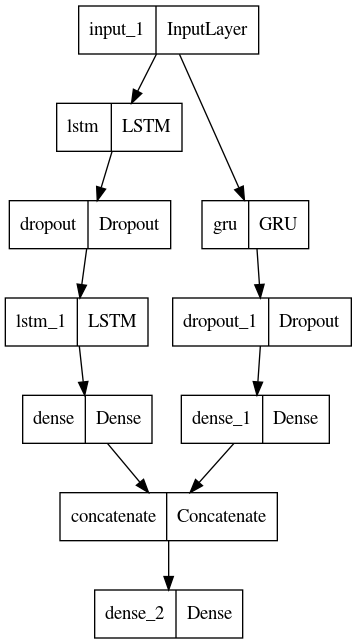

In [12]:
inputs = Input(shape = (window_length , features) )

#From deep learning in python -- better to use recurrent dropout so error propergates correctly
x = LSTM(30 , return_sequences = True )(inputs)
x = Dropout(0.01)(x) 
x = LSTM(50)(x)
x = Dense(128)(x)

y = GRU(30,input_shape=(window_length , features))(inputs)
y = Dropout(0.01)(y)
y = Dense(128)(y)

final = Concatenate()([x,y])
final = Dense(1)(final)

model = tf.keras.Model(inputs=inputs, outputs= final)

model.summary()
plot_model(model)

<Strong> Compiling the model </Strong>

In [13]:
model.compile(optimizer='adam' , loss = 'mse')

<Strong> Creating a callback to avail of early stopping </Strong>

In [14]:
earlyStopping = EarlyStopping(monitor = 'val_loss' , patience = 30 , mode = 'min' , verbose = 1)

<Strong> Training the model and storing the epoch where training stopped </Strong>

In [15]:
#Validation set needs to be in a tuple with x , y
history = model.fit(eth_train[0] , eth_train[1] , validation_data = eth_val  , batch_size = 512  , epochs =300 , verbose = 1 , callbacks = [earlyStopping] )
num_epochs = earlyStopping.stopped_epoch


Epoch 1/300


2022-03-08 16:08:56.229395: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200


54/54 [==============================] - 10s 27ms/step - loss: 0.0054 - val_loss: 0.0182
Epoch 2/300
54/54 [==============================] - 1s 16ms/step - loss: 5.6740e-05 - val_loss: 0.0153
Epoch 3/300
54/54 [==============================] - 0s 8ms/step - loss: 4.8861e-05 - val_loss: 0.0160
Epoch 4/300
54/54 [==============================] - 0s 8ms/step - loss: 4.8883e-05 - val_loss: 0.0146
Epoch 5/300
54/54 [==============================] - 0s 8ms/step - loss: 4.7030e-05 - val_loss: 0.0156
Epoch 6/300
54/54 [==============================] - 0s 8ms/step - loss: 4.6391e-05 - val_loss: 0.0166
Epoch 7/300
54/54 [==============================] - 0s 8ms/step - loss: 4.4617e-05 - val_loss: 0.0158
Epoch 8/300
54/54 [==============================] - 0s 8ms/step - loss: 4.4172e-05 - val_loss: 0.0147
Epoch 9/300
54/54 [==============================] - 0s 8ms/step - loss: 4.5089e-05 - val_loss: 0.0131
Epoch 10/300
54/54 [==============================] - 0s 8ms/step - loss: 4.3472e-05 -

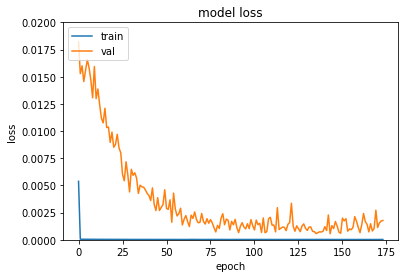

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.ylim([0,0.02])
plt.show()

<Strong> Testing on the validation data once again , hyper-parameter adjustment. <Strong>

In [17]:
validation_predict = model.predict(eth_val[0])
validation_predict = scaler.inverse_transform(validation_predict)

validation_actual = scaler.inverse_transform(eth_val[1])
math.sqrt(mean_squared_error(validation_actual , validation_predict))

56.87838546599425

<Strong> Combining the train and validation set when perfected hyper-parameters and training on fresh model. </Strong>

In [18]:
train_and_val = np.concatenate([eth_train[0] , eth_val[0]] )
train_and_val_targets = np.concatenate([eth_train[1] , eth_val[1] ])

freshModel = tf.keras.Model(inputs=inputs, outputs= final)
freshModel.compile(optimizer='adam' , loss = 'mse')

final = freshModel.fit(train_and_val , train_and_val_targets , batch_size = 512  , epochs = num_epochs , verbose = 1 )

Epoch 1/173
69/69 [==============================] - 4s 8ms/step - loss: 3.0992e-04
Epoch 2/173
69/69 [==============================] - 0s 7ms/step - loss: 1.5651e-04
Epoch 3/173
69/69 [==============================] - 0s 7ms/step - loss: 1.6212e-04
Epoch 4/173
69/69 [==============================] - 0s 7ms/step - loss: 1.7087e-04
Epoch 5/173
69/69 [==============================] - 0s 7ms/step - loss: 1.5618e-04
Epoch 6/173
69/69 [==============================] - 0s 7ms/step - loss: 1.5204e-04
Epoch 7/173
69/69 [==============================] - 0s 7ms/step - loss: 1.5821e-04
Epoch 8/173
69/69 [==============================] - 0s 7ms/step - loss: 1.4816e-04
Epoch 9/173
69/69 [==============================] - 0s 7ms/step - loss: 1.6338e-04
Epoch 10/173
69/69 [==============================] - 0s 7ms/step - loss: 1.5366e-04
Epoch 11/173
69/69 [==============================] - 0s 7ms/step - loss: 1.6077e-04
Epoch 12/173
69/69 [==============================] - 0s 7ms/step - loss: 

<Strong> Finally testing on test set and grabbing evaluation metrics </Strong>

In [19]:
test_predict = freshModel.predict(eth_test[0])
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(eth_test[1])

In [20]:
print(math.sqrt(mean_absolute_error(test_actual , test_predict)))
print(math.sqrt(mean_absolute_percentage_error(test_actual , test_predict)))
print(math.sqrt(mean_squared_error(test_actual , test_predict , squared = False)))
print(math.sqrt(mean_squared_error(test_actual , test_predict)))

6.862579127527321
0.11235363078672028
7.450655145008023
55.512262089834515


<Strong> For Predicting more than 1 day in the future - Test Set. </Strong>

In [21]:
def steps_in_future(hours_in_future , data):
    
    #All the hours_in_future time predictions
    predictions = []
    
    # Have to cut off the (hours_in_future - 1) off the test set to avoid out of bounds error
    test_data = data[0][:-(hours_in_future - 1)]
    
    for x in range (len(test_data)):
        #Going through all the windows
        last_window = test_data[x].reshape(1,-1)
    
            # Make as many predictions as hours_in_future
        for i in range(hours_in_future):
            
            # Take the predicted value from the last window in training set
            last_prediction = model.predict(last_window)[0]

            #shifting the window size one step down
            last_window[0] = np.roll(last_window[0], -1)

            #replacing the old value with new prediction
            last_window[0 , (len(last_window[0]) - 1)] = last_prediction

        #append prediction
        predictions.append(last_prediction)
    
    return predictions

In [22]:
three_day_predictions = steps_in_future(3, eth_test)
seven_day_predictions = steps_in_future( 7, eth_test)

In [23]:
scaled_three_day_predictions = scaler.inverse_transform(three_day_predictions)
scaled_seven_day_predictions = scaler.inverse_transform(seven_day_predictions)

In [25]:
# Targets to compare  
targets_in_future_three = eth_test[1][(3 - 1):]
targets_in_future_three = scaler.inverse_transform(targets_in_future_three)

targets_in_future_seven = eth_test[1][(7 - 1):]
targets_in_future_seven = scaler.inverse_transform(targets_in_future_seven)

In [28]:
print(math.sqrt(mean_absolute_error(targets_in_future_three , scaled_three_day_predictions)))
#print(math.sqrt(mean_absolute_error(targets_in_future_seven , scaled_seven_day_predictions)))

print(math.sqrt(mean_squared_error(targets_in_future_three , scaled_three_day_predictions )))
#print(math.sqrt(mean_squared_error(targets_in_future_seven , scaled_seven_day_predictions )))

print(math.sqrt(mean_squared_error(targets_in_future_three , scaled_three_day_predictions , squared = False)))
#print(math.sqrt(mean_squared_error(targets_in_future_seven , scaled_seven_day_predictions , squared = False)))

print(math.sqrt(mean_absolute_percentage_error(targets_in_future_three , scaled_three_day_predictions)))
#print(math.sqrt(mean_absolute_percentage_error(targets_in_future_seven , scaled_seven_day_predictions)))

10.966559132813941
133.87429421036944
11.570405965668163
0.17923261223487785
